# Vision Application feat. Google Cloud Vision API

## 初始化：建立GCP服務連線

In [53]:
import os

from google.cloud import vision

YOUR_SERVICE = 'YOUR_SERVICE ACCOUNT KEY'   # YOUR_SERVICE ACCOUNT KEY(a json file)

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = YOUR_SERVICE
client = vision.ImageAnnotatorClient()

## 上傳圖檔至GCP vision

In [54]:
# one-shot upload

YOUR_PIC = r'.\some_plate.jpg'

with open(YOUR_PIC, 'rb') as image_file:
    content = image_file.read()
image = vision.Image(content=content)

## object_localization
* 偵測圖片中物體

In [55]:
response = client.object_localization(image=image)

In [56]:
# Google object localization可辨識多種物體
response

localized_object_annotations {
  mid: "/m/083wq"
  name: "Wheel"
  score: 0.93921423
  bounding_poly {
    normalized_vertices {
      x: 0.744018853
      y: 0.741939127
    }
    normalized_vertices {
      x: 0.877432406
      y: 0.741939127
    }
    normalized_vertices {
      x: 0.877432406
      y: 0.874899209
    }
    normalized_vertices {
      x: 0.744018853
      y: 0.874899209
    }
  }
}
localized_object_annotations {
  mid: "/m/0k4j"
  name: "Car"
  score: 0.871785641
  bounding_poly {
    normalized_vertices {
      x: 0.146253571
      y: 0.465593368
    }
    normalized_vertices {
      x: 0.991045952
      y: 0.465593368
    }
    normalized_vertices {
      x: 0.991045952
      y: 0.882648766
    }
    normalized_vertices {
      x: 0.146253571
      y: 0.882648766
    }
  }
}
localized_object_annotations {
  mid: "/m/01jfm_"
  name: "License plate"
  score: 0.839915931
  bounding_poly {
    normalized_vertices {
      x: 0.263381064
      y: 0.675850332
    }
    n

[690.0583875179291, 1131.034300327301]
[3146.75914478302, 3459.177523612976]
(313, 441, 3)


(<AxesSubplot:title={'center':'car_plate'}>,
 Text(0.5, 1.0, 'car_plate'))

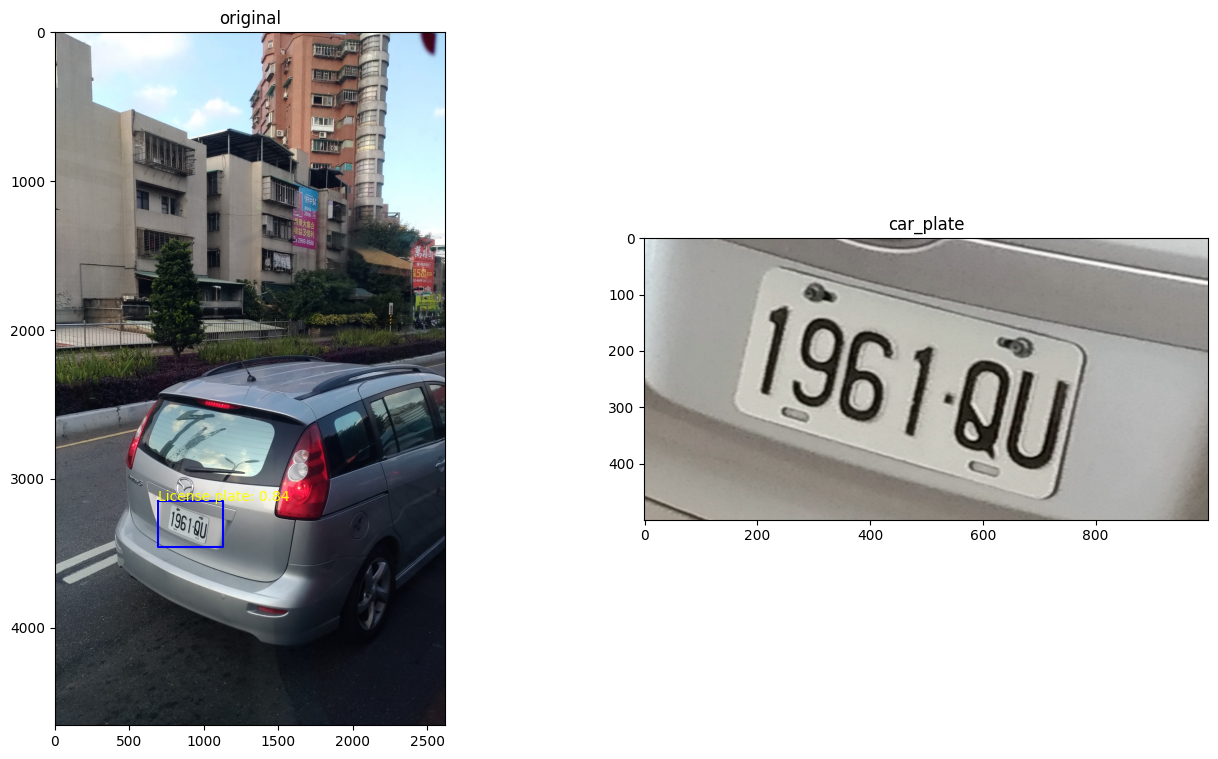

In [64]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2

im = Image.open(YOUR_PIC)
img = cv2.imread(YOUR_PIC)

target = 'License plate'  # 目標是車牌

plt.figure(figsize=(16, 9))
plt.subplot(121), plt.imshow(im), plt.title('original')


w, h = im.size
for obj in response.localized_object_annotations:
    if obj.name == target:
        desc = f'{obj.name}: {obj.score:.2f}'
        a = [(v.x * w, v.y * h) for v in obj.bounding_poly.normalized_vertices]
        a.append(a[0])
        x, y = zip(*a)
        
        # 定位出車牌位置
        sx = set(x)
        sy = set(y)
        lx = list(sx)
        ly = list(sy)
        print(lx)
        print(ly)
        
        plt.plot(x, y, color='blue')
        plt.text(x[0], y[0], desc, color='yellow')
        
        # 對車牌位置切割，只取車牌圖片
        crop_img = img[int(ly[0]):int(ly[1]), int(lx[0]):int(lx[1])]
        

print(crop_img.shape)  # (313, 441, 3)

# 對車牌圖片進行縮放來使後續文字辨識準確率提升
crop_mod = cv2.resize(crop_img, (1000, 500))
# cv2.imshow('cropped_mod', crop_mod)
cv2.imwrite('cropped_mod.jpg', crop_mod)
cv2.waitKey(0)
cv2.destroyAllWindows()


plt.subplot(122), plt.imshow(crop_mod), plt.title('car_plate')


## 上傳車牌圖檔至GCP vision

In [65]:
# one-shot upload

YOUR_PIC = 'cropped_mod.jpg'

with open(YOUR_PIC, 'rb') as image_file:
    content = image_file.read()
image = vision.Image(content=content)

## text_detection
* 偵測圖片中的文字

In [66]:
response = client.text_detection(image=image)

In [67]:
response

text_annotations {
  locale: "fr"
  description: "1961 QU"
  bounding_poly {
    vertices {
      x: 179
      y: 117
    }
    vertices {
      x: 762
      y: 117
    }
    vertices {
      x: 762
      y: 409
    }
    vertices {
      x: 179
      y: 409
    }
  }
}
text_annotations {
  description: "1961"
  bounding_poly {
    vertices {
      x: 218
      y: 117
    }
    vertices {
      x: 537
      y: 199
    }
    vertices {
      x: 497
      y: 351
    }
    vertices {
      x: 179
      y: 269
    }
  }
}
text_annotations {
  description: "QU"
  bounding_poly {
    vertices {
      x: 570
      y: 208
    }
    vertices {
      x: 762
      y: 257
    }
    vertices {
      x: 723
      y: 408
    }
    vertices {
      x: 531
      y: 359
    }
  }
}
full_text_annotation {
  pages {
    property {
      detected_languages {
        language_code: "fr"
        confidence: 1
      }
    }
    width: 1000
    height: 500
    blocks {
      bounding_box {
        vertices {
 

1961 QU


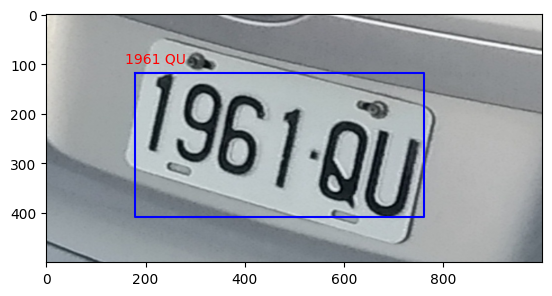

In [68]:
import matplotlib.pyplot as plt
from PIL import Image

im = Image.open('cropped_mod.jpg')

plt.imshow(im)

for text in response.text_annotations:
    if len(text.description) >= 6:  # 只取符合車牌長度的結果
        plate_desc = text.description
        print(plate_desc)
        a = [(v.x, v.y) for v in text.bounding_poly.vertices]
        a.append(a[0])
        x, y = zip(*a)
        plt.plot(x, y, color='blue')
        plt.text(x[0]-20, y[0]-20, plate_desc, color='red')

plt.show()